<a href="https://colab.research.google.com/github/awesomemj/capstone_fa2024/blob/main/Listing_Price_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import library

In [27]:
pip install category_encoders

In [82]:
# The warnings this notebook generates can be ignored -- most are irrelevant errors for this workflow.
import warnings
warnings.filterwarnings('ignore')


# Data manipulation packages.
import pandas as pd
import numpy as np
import pickle
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Machine learning preprocssing packages.

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import category_encoders as ce

# Machine learning performance monitoring packages.
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, make_scorer

# Data visualization packages.
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import matplotlib.patheffects as pe
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
mpl.rcParams['font.family'] = 'monospace'

# Machine learning models.
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, Lars, LassoLars,
    OrthogonalMatchingPursuit, SGDRegressor, PassiveAggressiveRegressor, HuberRegressor,
    RANSACRegressor, TheilSenRegressor
)
from sklearn.ensemble import (
    RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
    AdaBoostRegressor, HistGradientBoostingRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# For tracking operations in the notebook.
from tqdm import tqdm

## Load and merge datasets

In [83]:
zillow_df = pd.read_csv('BACKUP cleaned_zillow_data.csv')
print(zillow_df.shape)
zillow_df.head()

(128960, 117)


,Unnamed: 0,zillowId,homeStatus,streetAdress,city,state,zipcode,price,bedrooms,bathrooms,yearBuilt,zestimate,homeType,livingArea,hasGarage,parkingCapacity,sewer,hasHeating,fireplaces,hasWaterfrontView,isSeniorCommunity,levels,lotSize,hoaFee,buyersFeePerc,daysOnZillow,views,favorites,latitude,longitude,mainPhoto,brokerage,percSellFaster,propertyTax,mortgageRate,listingUserId,agentName,agentRating,agentRecentSales,agentReviewsCount,photosList,isForeclosure,isBankOwned,rentZestimate,totalActualRent,annual_house_insurance,price_history,description,similarHomes,termsCash,termsConventional,termsFHA,termsVA,schoolAverageDistance,schoolContainsCharter,schoolRatingElementary,schoolRatingMiddleSchool,schoolRatingHighSchool,hasPatioPorch,ngram_dolean,ngram_options vast endless,ngram_possibilities,ngram_community design exclusive,ngram_estate,ngram_stewarded,ngram_lucite,ngram_arclinea,ngram_marble block kitchen,ngram_downtown ocean best,ngram_brand arclinea entertainers,ngram_bathrooms magnificient guest,ngram_macassar,ngram_wine,ngram_masterpiece,ngram_private,ngram_cellar,ngram_infinity,ngram_expansive,ngram_intracoastalview,ngram_designed,ngram_chefs,ngram_parties grand,ngram_court tennis house,ngram_regencystyle,ngram_art deco gates,ngram_imposing main house,ngram_mansions dotting nearby,ngram_luxury,ngram_unparalleled,ngram_marble,ngram_architect,ngram_theater,ngram_outside scenery,ngram_staff,ngram_massage room,ngram_custom,ngram_magnificent,ngram_extraordinary,ngram_privately owned island,ngram_gourmet,ngram_iconic,ngram_stunning,ngram_infinityedge,ngram_panoramic,ngram_unobstructued sunrise sunset,ngram_aged white,ngram_experience perfect relaxation,ngram_indooroutdoor,ngram_court,ngram_architectural,ngram_subzero,ngram_rarefied,ngram_antiquities,ngram_sauna,ngram_terrace,ngram_saota,ngram_italian
0,2,23352313.0,FOR_SALE,7001 Palm Lane,Anacortes,WA,98221.0,2498000.0,4.0,3.0,2000.0,NaN,SingleFamily,3788.0,True,4.0,sewer,True,2.0,False,False,1.0,10.300000,0.0,2.5,125.0,1219.0,40.0,48.441994,-122.591225,https://photos.zillowstatic.com/fp/8a6b6abe798...,COMPASS,0.25,0.83,6.606,X1-ZUyt9ezy9pvtop_61q4w,Eileen Hebert,5.0,1.0,259.0,"[""https://photos.zillowstatic.com/fp/8a6b6abe7...",False,False,NaN,0.0,10491.6,"[[""2023-10-11"", 2498000], [""1994-06-27"", 308000]]",exquisite equestrian oasis perfect blend luxur...,"[84763318, 23352179, 23377656, 23387845, 20536...",False,True,False,False,3.200000,False,9.0,5.0,9.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,3,23380009.0,FOR_SALE,14820 Gibralter Road,Anacortes,WA,98221.0,5300000.0,5.0,6.0,2001.0,NaN,SingleFamily,5577.0,True,4.0,sewer,True,4.0,False,False,1.0,17.010000,0.0,2.5,276.0,2146.0,127.0,48.429980,-122.587870,https://photos.zillowstatic.com/fp/3a101f623ea...,"Windermere R.E. Northeast, Inc",0.22,0.83,6.606,X1-ZUz3sd58bhvnd5_3qul1,bryanloveless5250,5.0,0.0,9.0,"[""https://photos.zillowstatic.com/fp/3a101f623...",False,False,NaN,0.0,22260.0,"[[""2023-03-21"", 5300000], [""2015-11-30"", 21500...",saratoga stablesa magnificent gated acre eques...,"[2055432779, 2053658449, 228491857, 82573373, ...",False,True,False,False,4.033333,False,9.0,5.0,9.0,False,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,23352179.0,FOR_SALE,7270 Old Brook Lane,Anacortes,WA,98221.0,1499000.0,5.0,4.0,1983.0,1391500.0,SingleFamily,2968.0,True,2.0,sewer,True,2.0,False,False,2.0,9.010000,0.0,2.5,94.0,936.0,29.0,48.460000,-122.587746,https://photos.zillowstatic.com/fp/99488e836da...,Windermere RE Anacortes Prop.,0.30,0.83,6.606,X1-ZUz4p08auiqhhl_3wgux,Colleen Craig,5.0,0.0,9.0,"[""https://photos.zillowstatic.com/fp/99488e836...",False,False,5818.0,0.0,6295.8,"[[""2023-09-19"", 1499000], [""2013-07-03"", 1900]...",lovely cape code style home northwest twist po...,"[23358076, 23377656, 23358089, 23387845, 25075...",False,True,False,False,2.633333,False,9.0,5.0,9.0,

In [84]:
junk_df = pd.read_csv('inferredJunkListings.csv')
print(junk_df.shape)
junk_df.head()

(72234, 4)


,Unnamed: 0,zillowId,isJunk,description
0,0,23352313.0,False,NaN
1,1,23380009.0,False,NaN
2,2,23352179.0,False,NaN
3,3,23377187.0,True,"(True, 'The listing mentions a tenant being ev..."
4,4,23377249.0,False,NaN


In [85]:
poi_df = pd.read_csv('BACKUP points_of_interest_data.csv')
print(poi_df.shape)
poi_df.head()

(218700, 62)


,Unnamed: 0,zillowId,national_park,post_office,tiny_museum,small_museum,medium_museum,large_museum,massive_museum,top_trail,hidden_gem_trail,tougth_to_love_trail,under_the_radar_trail,prison,clean_power_plant,dirty_power_plant,police_station,most_serious_crimes_per_capita,serious_crimes_per_capita,less_serious_crimes_per_capita,total_stolen_value_per_capita,zipcode,county,state,latitude,longitude,2022_county_pop,City Tier,close_atlantic,close_pacific,close_great_lakes,in_mountains,mountain_range,stateAbbrev,riskScore,riskRating,expectedAnnualLossScore,expectedAnnualLossRating,expectedAnnualLossTotal,socialVulnerabilityScore,socialVulnerabilityRating,resiliencyScore,resiliencyRating,avalancheAnnualizedFrequency,coastalFloodingAnnualizedFrequency,coldWaveAnnualizedFrequency,droughtAnnualizedFrequency,earthquakeAnnualizedFrequency,hailAnnualizedFrequency,heatWaveAnnualizedFrequency,hurricanAnnualizedFrequency,iceStormAnnualizedFrequency,landslideAnnualizedFrequency,lightningAnnualizedFrequency,riverineFloodingAnnualizedFrequency,strongWindAnnualizedFrequency,tornadoAnnualizedFrequency,tsunamiAnnualizedFrequency,volcanicActivityAnnualizedFrequency,wildFireAnnualizedActivity,winterWeatherAnnualizedFrequency,comps
0,0,2.091639e+09,72.027601,1.379914,2.083139,3.771063,10.751508,11.630574,715.644631,1.545938,8.704046,1.549382,3.779635,11.860081,8.383790,13.522065,2.375861,0.000000,0.043216,0.046818,53907.0,98370.0,Kitsap County,Washington,47.762417,-122.545630,277673.0,Tier 5,False,True,False,False,NaN,WA,94.527521,Relatively Moderate,94.924172,Relatively Moderate,8.281586e+07,30.809999,Relatively Low,76.769997,Relatively High,0.0,3.176718,0.0,0.1835,0.00856,0.01555,1.437791,0.0,0.633813,0.024124,0.689767,0.041667,0.00823,0.015567,0.0,0.000524,0.000011,1.42161,190080.0
1,1,2.056520e+09,54.730437,2.205721,3.292446,9.167639,7.824371,10.439142,697.056733,1.926547,8.189904,2.987584,1.360101,6.607345,11.509342,13.232421,8.794134,0.054020,3.709399,1.386523,1312139.0,98070.0,Kitsap County,Washington,47.494846,-122.461720,277673.0,Tier 5,False,True,False,False,NaN,WA,94.527521,Relatively Moderate,94.924172,Relatively Moderate,8.281586e+07,30.809999,Relatively Low,76.769997,Relatively High,0.0,3.176718,0.0,0.1835,0.00856,0.01555,1.437791,0.0,0.633813,0.024124,0.689767,0.041667,0.00823,0.015567,0.0,0.000524,0.000011,1.42161,1646950.0
2,2,4.879752e+07,54.340696,2.259702,2.048503,10.549123,9.315314,12.291097,695.616400,1.061378,7.293344,3.306099,0.490755,8.338395,13.087109,15.082613,8.418672,0.054020,3.709399,1.386523,1312139.0,98070.0,Kitsap County,Washington,47.473576,-122.485916,277673.0,Tier 5,False,True,False,False,NaN,WA,94.527521,Relatively Moderate,94.924172,Relatively Moderate,8.281586e+07,30.809999,Relatively Low,76.769997,Relatively High,0.0,3.176718,0.0,0.1835,0.00856,0.01555,1.437791,0.0,0.633813,0.024124,0.689767,0.041667,0.00823,0.015567,0.0,0.000524,0.000011,1.42161,754000.0
3,3,2.085531e+09,54.725388,2.213816,3.296159,9.156786,7.812322,10.429281,697.059486,1.930630,8.189268,2.996164,1.369777,6.597600,11.505590,13.223405,8.804077,0.054020,3.709399,1.386523,1312139.0,98070.0,Kitsap County,Washington,47.494890,-122.461470,277673.0,Tier 5,False,True,False,False,NaN,WA,94.527521,Relatively Moderate,94.924172,Relatively Moderate,8.281586e+07,30.809999,Relatively Low,76.769997,Relatively High,0.0,3.176718,0.0,0.1835,0.00856,0.01555,1.437791,0.0,0.633813,0.024124,0.689767,0.041667,0.00823,0.015567,0.0,0.000524,0.000011,1.42161,1646950.0
4,4,9.669307e+07,53.315705,2.198448,2.113255,9.668172,7.640726,11.138042,695.712437,0.977481,6.739546,4.268089,1.484019,7.367067,12.817583,14.053218,7.645239,0.014405,0.925549,0.641042,233934.0,98070.0,Kitsap County,Washington,47.475597,-122.448630,277673.0,Tier 5,False,True,False,False,NaN,WA,94.527521,Relatively Moderate,94.924172,Relatively Moderate,8.281586e+07,30.809999,Relatively Low,76.769997,Relatively High,0.0,3.176718,0.0,0.1835,0.00856,0.01555,1.437791,0.0,0.633813,0.024124,0.689767,0.041667,0.

### Data cleaning

In [86]:
# Remove the unnecessary columns and drop duplicate rows
junk_df = junk_df.drop(['Unnamed: 0', 'description'], axis = 1).drop_duplicates()

In [87]:
# Remove rows with conflicting junk determination results
grouped = junk_df.groupby('zillowId')
non_identical_duplicates = grouped.filter(lambda x: len(x) > 1 and len(x.drop_duplicates()) > 1)

junk_df = junk_df[~(junk_df['zillowId'].isin(non_identical_duplicates['zillowId'].unique()))]

In [88]:
# Remove the unnecessary columns and drop duplicate rows
poi_df.drop(['Unnamed: 0', 'zipcode', 'county', 'state', 'latitude', 'longitude'], axis = 1, inplace = True)
poi_df.drop_duplicates(inplace=True)

In [89]:
# Remove rows where zillowId appears more than once but with non-identical values in other columns
grouped = poi_df.groupby('zillowId')
non_identical_duplicates = grouped.filter(lambda x: len(x) > 1 and len(x.drop_duplicates()) > 1)

poi_df = poi_df[~(poi_df['zillowId'].isin(non_identical_duplicates['zillowId'].unique()))]

In [90]:
df = zillow_df.merge(junk_df, on='zillowId', how='left')
df = df.merge(poi_df, on='zillowId', how='left')

print(df.shape)
df.head()

(128960, 173)


,Unnamed: 0,zillowId,homeStatus,streetAdress,city,state,zipcode,price,bedrooms,bathrooms,yearBuilt,zestimate,homeType,livingArea,hasGarage,parkingCapacity,sewer,hasHeating,fireplaces,hasWaterfrontView,isSeniorCommunity,levels,lotSize,hoaFee,buyersFeePerc,daysOnZillow,views,favorites,latitude,longitude,mainPhoto,brokerage,percSellFaster,propertyTax,mortgageRate,listingUserId,agentName,agentRating,agentRecentSales,agentReviewsCount,photosList,isForeclosure,isBankOwned,rentZestimate,totalActualRent,annual_house_insurance,price_history,description,similarHomes,termsCash,termsConventional,termsFHA,termsVA,schoolAverageDistance,schoolContainsCharter,schoolRatingElementary,schoolRatingMiddleSchool,schoolRatingHighSchool,hasPatioPorch,ngram_dolean,ngram_options vast endless,ngram_possibilities,ngram_community design exclusive,ngram_estate,ngram_stewarded,ngram_lucite,ngram_arclinea,ngram_marble block kitchen,ngram_downtown ocean best,ngram_brand arclinea entertainers,ngram_bathrooms magnificient guest,ngram_macassar,ngram_wine,ngram_masterpiece,ngram_private,ngram_cellar,ngram_infinity,ngram_expansive,ngram_intracoastalview,ngram_designed,ngram_chefs,ngram_parties grand,ngram_court tennis house,ngram_regencystyle,ngram_art deco gates,ngram_imposing main house,ngram_mansions dotting nearby,ngram_luxury,ngram_unparalleled,ngram_marble,ngram_architect,ngram_theater,ngram_outside scenery,ngram_staff,ngram_massage room,ngram_custom,ngram_magnificent,ngram_extraordinary,ngram_privately owned island,ngram_gourmet,ngram_iconic,ngram_stunning,ngram_infinityedge,ngram_panoramic,ngram_unobstructued sunrise sunset,ngram_aged white,ngram_experience perfect relaxation,ngram_indooroutdoor,ngram_court,ngram_architectural,ngram_subzero,ngram_rarefied,ngram_antiquities,ngram_sauna,ngram_terrace,ngram_saota,ngram_italian,isJunk,national_park,post_office,tiny_museum,small_museum,medium_museum,large_museum,massive_museum,top_trail,hidden_gem_trail,tougth_to_love_trail,under_the_radar_trail,prison,clean_power_plant,dirty_power_plant,police_station,most_serious_crimes_per_capita,serious_crimes_per_capita,less_serious_crimes_per_capita,total_stolen_value_per_capita,2022_county_pop,City Tier,close_atlantic,close_pacific,close_great_lakes,in_mountains,mountain_range,stateAbbrev,riskScore,riskRating,expectedAnnualLossScore,expectedAnnualLossRating,expectedAnnualLossTotal,socialVulnerabilityScore,socialVulnerabilityRating,resiliencyScore,resiliencyRating,avalancheAnnualizedFrequency,coastalFloodingAnnualizedFrequency,coldWaveAnnualizedFrequency,droughtAnnualizedFrequency,earthquakeAnnualizedFrequency,hailAnnualizedFrequency,heatWaveAnnualizedFrequency,hurricanAnnualizedFrequency,iceStormAnnualizedFrequency,landslideAnnualizedFrequency,lightningAnnualizedFrequency,riverineFloodingAnnualizedFrequency,strongWindAnnualizedFrequency,tornadoAnnualizedFrequency,tsunamiAnnualizedFrequency,volcanicActivityAnnualizedFrequency,wildFireAnnualizedActivity,winterWeatherAnnualizedFrequency,comps
0,2,23352313.0,FOR_SALE,7001 Palm Lane,Anacortes,WA,98221.0,2498000.0,4.0,3.0,2000.0,NaN,SingleFamily,3788.0,True,4.0,sewer,True,2.0,False,False,1.0,10.300000,0.0,2.5,125.0,1219.0,40.0,48.441994,-122.591225,https://photos.zillowstatic.com/fp/8a6b6abe798...,COMPASS,0.25,0.83,6.606,X1-ZUyt9ezy9pvtop_61q4w,Eileen Hebert,5.0,1.0,259.0,"[""https://photos.zillowstatic.com/fp/8a6b6abe7...",False,False,NaN,0.0,10491.6,"[[""2023-10-11"", 2498000], [""1994-06-27"", 308000]]",exquisite equestrian oasis perfect blend luxur...,"[84763318, 23352179, 23377656, 23387845, 20536...",False,True,False,False,3.200000,False,9.0,5.0,9.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,False,115.176073,5.317357,4.653399,7.910483,54.366848,55.808753,762.642100,1.766666,8.931811,7.085156,1.796508,10.752119,25.877619,2.451245,4.362211,0.02287,1.204461,1.257823,220121.0,131179.0,Tier 5,False,True,False,False,NaN,WA,89.118676,Relatively Moder

In [91]:
df[['close_atlantic', 'close_pacific', 'close_great_lakes', 'in_mountains', 'isJunk']] = \
    df[['close_atlantic', 'close_pacific', 'close_great_lakes', 'in_mountains', 'isJunk']].astype(bool)

In [92]:
# Drop junk lising
df = df[df['isJunk'] == False]

# Drop data to make it an easier data set to work with.
df = df[df['price'] < df['price'].quantile(0.99)]
df = df[df['homeType']!='VacantLand']
df = df[df['price'] > 1000]
df = df[~df['bathrooms'].isnull()]
df = df[~df['bedrooms'].isnull()]

# Move the id to the index.
df.index = df['zillowId']

### Encode features

In [93]:
# Target Encoding for 'city' and 'state'
target_encoder = ce.TargetEncoder(cols=['city', 'state'])
df_encoded = target_encoder.fit_transform(df[['city', 'state']], df['price'])

# One-Hot Encoding for 'homeType' and 'sewer'
df_encoded = pd.concat([df_encoded, pd.get_dummies(df[['homeType', 'sewer']])], axis=1)

# Drop the original columns
df_encoded.drop(columns=['city', 'state'], inplace=True)

In [94]:
numerical_col = ['bedrooms', 'bathrooms', 'yearBuilt', 'livingArea',
                 'parkingCapacity', 'fireplaces', 'levels', 'lotSize', 'hoaFee',
                 'buyersFeePerc', 'daysOnZillow', 'views', 'favorites',
                 'percSellFaster', 'propertyTax', 'mortgageRate', 'agentRating',
                 'agentRecentSales', 'agentReviewsCount', 'totalActualRent',
                 'schoolAverageDistance', 'schoolRatingElementary',
                 'schoolRatingMiddleSchool', 'schoolRatingHighSchool',
                 #poi data
                 'national_park', 'post_office', 'tiny_museum', 'small_museum', 'medium_museum',
                 'large_museum', 'massive_museum','top_trail', 'hidden_gem_trail', 'tougth_to_love_trail',
                 'under_the_radar_trail', 'prison', 'clean_power_plant','dirty_power_plant',
                 'police_station', 'most_serious_crimes_per_capita', 'serious_crimes_per_capita',
                 'less_serious_crimes_per_capita', 'total_stolen_value_per_capita', '2022_county_pop',
                 'riskScore', 'expectedAnnualLossScore', 'expectedAnnualLossTotal', 'socialVulnerabilityScore',
                 'resiliencyScore', 'avalancheAnnualizedFrequency', 'coastalFloodingAnnualizedFrequency',
                 'coldWaveAnnualizedFrequency', 'droughtAnnualizedFrequency', 'earthquakeAnnualizedFrequency',
                 'hailAnnualizedFrequency', 'heatWaveAnnualizedFrequency', 'hurricanAnnualizedFrequency',
                 'iceStormAnnualizedFrequency', 'landslideAnnualizedFrequency', 'lightningAnnualizedFrequency',
                 'riverineFloodingAnnualizedFrequency', 'strongWindAnnualizedFrequency', 'tornadoAnnualizedFrequency',
                 'tsunamiAnnualizedFrequency', 'volcanicActivityAnnualizedFrequency', 'wildFireAnnualizedActivity',
                 'winterWeatherAnnualizedFrequency', 'comps', 'price']

ngram_col = ['ngram_dolean', 'ngram_options vast endless',
             'ngram_possibilities', 'ngram_community design exclusive',
             'ngram_estate', 'ngram_stewarded', 'ngram_lucite', 'ngram_arclinea',
             'ngram_marble block kitchen', 'ngram_downtown ocean best',
             'ngram_brand arclinea entertainers', 'ngram_bathrooms magnificient guest',
             'ngram_macassar', 'ngram_wine', 'ngram_masterpiece', 'ngram_private',
             'ngram_cellar', 'ngram_infinity', 'ngram_expansive',
             'ngram_intracoastalview', 'ngram_designed', 'ngram_chefs',
             'ngram_parties grand', 'ngram_court tennis house', 'ngram_regencystyle',
             'ngram_art deco gates', 'ngram_imposing main house',
             'ngram_mansions dotting nearby', 'ngram_luxury',
             'ngram_unparalleled', 'ngram_marble', 'ngram_architect',
             'ngram_theater', 'ngram_outside scenery', 'ngram_staff',
             'ngram_massage room', 'ngram_custom', 'ngram_magnificent',
             'ngram_extraordinary', 'ngram_privately owned island',
             'ngram_gourmet', 'ngram_iconic', 'ngram_stunning',
             'ngram_infinityedge', 'ngram_panoramic',
             'ngram_unobstructued sunrise sunset', 'ngram_aged white',
             'ngram_experience perfect relaxation', 'ngram_indooroutdoor',
             'ngram_court', 'ngram_architectural', 'ngram_subzero',
             'ngram_rarefied', 'ngram_antiquities', 'ngram_sauna',
             'ngram_terrace', 'ngram_saota', 'ngram_italian']

categorical_cols = ['hasGarage', 'hasHeating', 'hasWaterfrontView', 'isSeniorCommunity',
                    'isForeclosure', 'isBankOwned', 'termsCash', 'termsConventional',
                    'termsFHA', 'termsVA', 'hasPatioPorch', 'close_atlantic',
                    'close_pacific', 'close_great_lakes', 'in_mountains']

numerical_df = df[numerical_col]
ngram_df = df[ngram_col]
categorical_df = df[categorical_cols]

final_df = pd.concat([df_encoded, numerical_df, ngram_df, categorical_df], axis=1)

final_df.reset_index(drop=True, inplace=True)

print(final_df.shape)
final_df.head()

(67502, 153)


,homeType_Apartment,homeType_Condo,homeType_Cooperative,homeType_MobileManufactured,homeType_MultiFamily,homeType_SingleFamily,homeType_Townhouse,sewer_none,sewer_other,sewer_septic,sewer_sewer,bedrooms,bathrooms,yearBuilt,livingArea,parkingCapacity,fireplaces,levels,lotSize,hoaFee,buyersFeePerc,daysOnZillow,views,favorites,percSellFaster,propertyTax,mortgageRate,agentRating,agentRecentSales,agentReviewsCount,totalActualRent,schoolAverageDistance,schoolRatingElementary,schoolRatingMiddleSchool,schoolRatingHighSchool,national_park,post_office,tiny_museum,small_museum,medium_museum,large_museum,massive_museum,top_trail,hidden_gem_trail,tougth_to_love_trail,under_the_radar_trail,prison,clean_power_plant,dirty_power_plant,police_station,most_serious_crimes_per_capita,serious_crimes_per_capita,less_serious_crimes_per_capita,total_stolen_value_per_capita,2022_county_pop,riskScore,expectedAnnualLossScore,expectedAnnualLossTotal,socialVulnerabilityScore,resiliencyScore,avalancheAnnualizedFrequency,coastalFloodingAnnualizedFrequency,coldWaveAnnualizedFrequency,droughtAnnualizedFrequency,earthquakeAnnualizedFrequency,hailAnnualizedFrequency,heatWaveAnnualizedFrequency,hurricanAnnualizedFrequency,iceStormAnnualizedFrequency,landslideAnnualizedFrequency,lightningAnnualizedFrequency,riverineFloodingAnnualizedFrequency,strongWindAnnualizedFrequency,tornadoAnnualizedFrequency,tsunamiAnnualizedFrequency,volcanicActivityAnnualizedFrequency,wildFireAnnualizedActivity,winterWeatherAnnualizedFrequency,comps,price,ngram_dolean,ngram_options vast endless,ngram_possibilities,ngram_community design exclusive,ngram_estate,ngram_stewarded,ngram_lucite,ngram_arclinea,ngram_marble block kitchen,ngram_downtown ocean best,ngram_brand arclinea entertainers,ngram_bathrooms magnificient guest,ngram_macassar,ngram_wine,ngram_masterpiece,ngram_private,ngram_cellar,ngram_infinity,ngram_expansive,ngram_intracoastalview,ngram_designed,ngram_chefs,ngram_parties grand,ngram_court tennis house,ngram_regencystyle,ngram_art deco gates,ngram_imposing main house,ngram_mansions dotting nearby,ngram_luxury,ngram_unparalleled,ngram_marble,ngram_architect,ngram_theater,ngram_outside scenery,ngram_staff,ngram_massage room,ngram_custom,ngram_magnificent,ngram_extraordinary,ngram_privately owned island,ngram_gourmet,ngram_iconic,ngram_stunning,ngram_infinityedge,ngram_panoramic,ngram_unobstructued sunrise sunset,ngram_aged white,ngram_experience perfect relaxation,ngram_indooroutdoor,ngram_court,ngram_architectural,ngram_subzero,ngram_rarefied,ngram_antiquities,ngram_sauna,ngram_terrace,ngram_saota,ngram_italian,hasGarage,hasHeating,hasWaterfrontView,isSeniorCommunity,isForeclosure,isBankOwned,termsCash,termsConventional,termsFHA,termsVA,hasPatioPorch,close_atlantic,close_pacific,close_great_lakes,in_mountains
0,False,False,False,False,False,True,False,False,False,False,True,4.0,3.0,2000.0,3788.0,4.0,2.0,1.0,10.30,0.0,2.5,125.0,1219.0,40.0,0.25,0.83,6.606,5.0,1.0,259.0,0.0,3.200000,9.0,5.0,9.0,115.176073,5.317357,4.653399,7.910483,54.366848,55.808753,762.642100,1.766666,8.931811,7.085156,1.796508,10.752119,25.877619,2.451245,4.362211,0.02287,1.204461,1.257823,220121.0,131179.0,89.118676,88.734138,3.438425e+07,54.84,77.019997,0.15,3.357672,0.000002,1.603494,0.004858,0.022362,0.578482,0.0,0.457667,0.156369,0.979002,0.291667,0.015443,0.025371,0.004587,0.002336,0.000016,15.316117,2419400.0,2498000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,True,True,False,False,False,False,False,True,False,False,False,False,True,False,False
1,False,False,False,False,False,True,False,False,False,False,True,5.0,6.0,2001.0,5577.0,4.0,4.0,1.0,17.01,0.0,2.5,276.0,2146.0,127.0,0.22,0.83,6.606,5.0,0.0,9.0,0.0,4.033333,9.0,5.0,9.0,114.345454,5.076406,4.006401,7.959664,53.522861,54.964575,761.807544,1.686467,8.646967,6.242466,2.411505,9.990582,25.164813,3.096139,5.204071,0.02287,1.204461,1.257823,220121.0,131179.0,89.118676,88.734138

## Feature importance analysis

### 1. Tree-Based Models

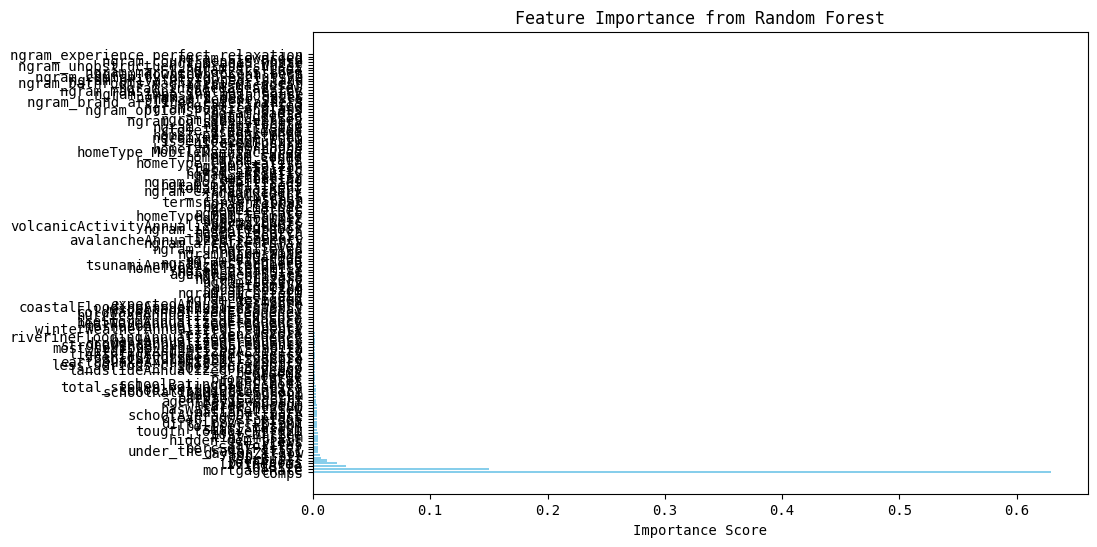

In [100]:
X = final_df.drop(columns=['price'])
y = final_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance from Random Forest')
plt.show()

### 2. Permutation Feature Importance

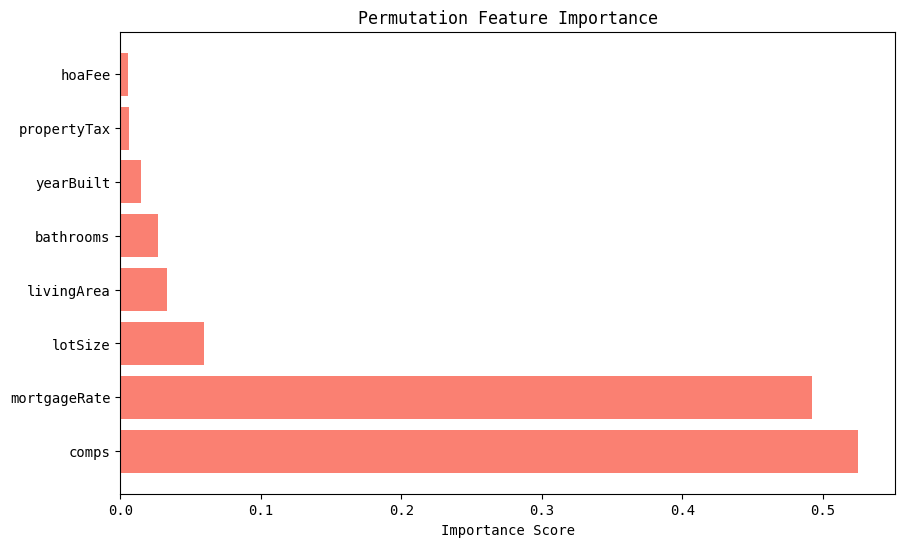

In [99]:
rf_model.fit(X_train, y_train)

perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=30, random_state=42)

perm_importance_df = pd.DataFrame({'feature': X.columns, 'importance': perm_importance.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['feature'], perm_importance_df['importance'], color='salmon')
plt.xlabel('Importance Score')
plt.title('Permutation Feature Importance')
plt.show()

In [101]:
 feature_importance_df.head(10)

,feature,importance
78,comps,0.629094
26,mortgageRate,0.150051
18,lotSize,0.027942
14,livingArea,0.020755
12,bathrooms,0.011691
13,yearBuilt,0.006725
42,top_trail,0.006272
21,daysOnZillow,0.004715
45,under_the_radar_trail,0.004477
24,percSellFaster,0.004422


In [102]:
perm_importance_df.head(10)

,feature,importance
0,comps,0.525119
1,mortgageRate,0.492149
4,lotSize,0.059370
3,livingArea,0.033289
2,bathrooms,0.027166
5,yearBuilt,0.014620
7,propertyTax,0.006131
6,hoaFee,0.005735


## Baseline Model
- Based on the feature importance analysis, the top three features—'comps', 'mortgageRate', 'lotSize', and 'livingArea'—are consistent across both methods. I will use these features to build the baseline model.

In [95]:
features = final_df[['comps', 'mortgageRate', 'lotSize', 'livingArea']]
target = final_df['price']

imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features_imputed, target, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

Mean Absolute Error (MAE): 182778.07873116384
Mean Squared Error (MSE): 138886827367.84958
Root Mean Squared Error (RMSE): 372675.23041899304
R^2 Score: 0.6765669053155632


In [96]:
selected_features = ['comps', 'mortgageRate', 'bathrooms', 'livingArea', 'lotSize', 'yearBuilt', 'hoaFee', 'propertyTax']
X = final_df[selected_features]
y = final_df['price']

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

ridge = Ridge()
params = {'alpha': [0.1, 1.0, 10.0, 100.0]}
ridge_cv = GridSearchCV(ridge, param_grid=params, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y_train)

y_pred = ridge_cv.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Best Alpha: {ridge_cv.best_params_['alpha']}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

Best Alpha: 0.1
Mean Absolute Error (MAE): 183035.55186054166
Mean Squared Error (MSE): 136009019973.29646
Root Mean Squared Error (RMSE): 368794.00750730274
R^2 Score: 0.683268607479591


In [98]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

grid_search = GridSearchCV(xgb, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}
Mean Absolute Error (MAE): 119358.05275448346
Mean Squared Error (MSE): 74816808356.40063
Root Mean Squared Error (RMSE): 273526.61361629993
R^2 Score: 0.8257701445146219
